## Hosting Capacity

The term PV hosting capacity is defined as the maximum PV capacity which can be connected to a specific grid, while still complying with relevant grid codes and grid planning principles. 

Here we will introduce a basic algorithm to calculate PV hosting capacity with pandapower.

The basic idea of calculating hosting capacity is to increase PV installation until a violation of any planning principle or constraint occurs. To analyse hosting capacity, we need three basic building blocks:
1. Evaluting constraint violations
2. Chosing connection points for new PV plants
3. Defining the installed power of new PV plants 

### Evaluation of constraint violations

Our example function that evaluates constraint violation is defined as:

In [1]:
import pandapower as pp

def violations(net):
    pp.runpp(net)
    if net.res_line.loading_percent.max() > 50:
        return (True, "Line \n Overloading")
    elif net.res_trafo.loading_percent.max() > 50:
        return (True, "Transformer \n Overloading")
    elif net.res_bus.vm_pu.max() > 1.04:
        return (True, "Voltage \n Violation")
    else:
        return (False, None)

The function runs a power flow and then checks for line loading and transformer loading (both of which have to be below 50%) and for voltage rise (which has to be below 1.04 pu). The function returns a boolean flag to signal if any constraint is violated as well as a string that indicates the type of constraint violation.

### Chosing a connection bus

If new PV plants are installed, a connection bus has to be chosen. Here, we chose one random bus of each of the buses that have a load connection:

In [6]:
from numpy.random import choice

def chose_bus(net):
    return choice(net.load.bus.values)

### Chosing a PV plant size

The function that returns a plant size is given as:

In [7]:
from numpy.random import normal

def get_plant_size_kw():
    return normal(loc=0.5, scale=0.05)

This function returns a random value from a normal distribution with a mean of 0.5 MW and a standard deviation of 0.005 MW. Depending on the existing information, it would also possible to use other probability distributions, such as a Weibull distribution, or to draw values from existing plant sizes.

### Evaluating Hosting Capacity

We now use these building blocks to evaluate hosting capacity in a generic network. We use the MV Oberrhein network from the pandapower networks package as an example:

In [8]:
import pandapower.networks as nw
def load_network():
    return nw.mv_oberrhein(scenario="generation")

The hosting capacity is then evaluated like this:

In [9]:
import pandas as pd

iterations = 50
results = pd.DataFrame(columns=["installed", "violation"])

for i in range(iterations):
    net = load_network()
    installed_kw = 0
    while 1:
        violated, violation_type = violations(net)
        if violated:
            results.loc[i] = [installed_kw, violation_type]
            break
        else:
            plant_size = get_plant_size_kw()
            pp.create_sgen(net, chose_bus(net), p_mw=plant_size, q_mvar=0)
            installed_kw += plant_size

This algorithm adds new PV plants until a violation of any constraint occurs. Then, it saves the installed PV capacity. This is carried out for a number of iteration (here: 50) to get a distribution of hosting capacity values depending on connection points and plant sizes.

The results can be visualized using pandas/matplotlib:

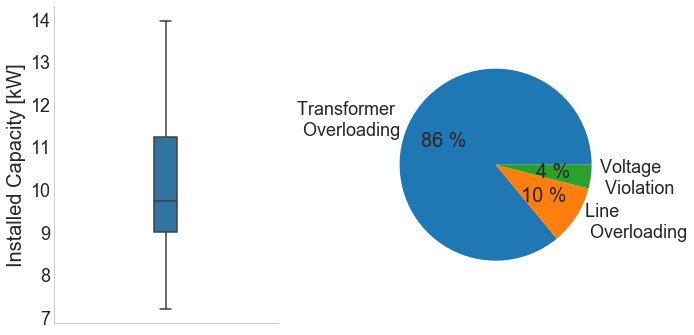

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # fontsize of the tick labels
plt.rc('axes', labelsize=20)    # fontsize of the tick labels
plt.rcParams['font.size'] = 20

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = axes[0]
sns.boxplot(results.installed, width=.1, ax=ax, orient="v")
ax.set_xticklabels([""])
ax.set_ylabel("Installed Capacity [kW]")

ax = axes[1]
ax.axis("equal")
results.violation.value_counts().plot(kind="pie", ax=ax,  autopct=lambda x:"%.0f %%"%x)
ax.set_ylabel("")
ax.set_xlabel("")
sns.despine()
plt.tight_layout()

Note that this is only an example for a basic algorithm in order to demonstrate how such problems can be tackled with pandapower. Algorithms applied in real case studies might include Q-control of PV plants, transformer tap controllers, more sophisticated distribution of PV plants, probability distribution different buses, binary search for the hosting capacity evaluation etc.